In [374]:
#import numpy as np
import numpy.random as npr

import jax
import jax.numpy as jnp 
import jax.random as jrnd
import jax.scipy.stats as jsps
import jax.scipy.linalg as spla
from jax.config import config
config.update("jax_enable_x64", True)
from jax.scipy.stats import gaussian_kde

import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from search_no_gpjax import generate_true_function
from scipy.spatial import ConvexHull

In [375]:
def convelope(design_space, knot_y):

    N, D = design_space.shape
    deriv_marg_var = 100
    #d_kernel = jax.jit(jax.vmap(jax.grad(jax.grad(lambda x1, x2, ls: kernel_old(x1, x2, ls)[0,0], argnums=0), argnums=1), in_axes=(0,0,None)))
    # TODO: 
    #deriv_marg_var = np.max(jnp.diag(d_kernel(knot_x, knot_x, ls)))
    #print(deriv_marg_var)
    s = jnp.linspace(-3*jnp.sqrt(deriv_marg_var), 3*jnp.sqrt(deriv_marg_var), 500)
    ss = jnp.meshgrid(*[s.ravel()]*D)
    s = jnp.array([sx.flatten() for sx in ss]).T

    knot_y = jnp.atleast_2d(knot_y) # samples x num_primal
    #print(knot_y.shape)
    
    prod = (design_space @ s.T).T
    #print(prod.shape)
    
    # compute the conjugate
    lft1 = jnp.max(prod[jnp.newaxis,:,:] - knot_y[:,jnp.newaxis,:],  axis=2) # samples x num_dual
    #print(lft1.shape)
    # compute the biconjugate
    lft2 = jnp.max(prod[jnp.newaxis,:,:] - lft1[:,:,jnp.newaxis],  axis=1) # samples x num_primal
    
    return lft2

In [458]:
import numpy as np
from scipy.spatial import ConvexHull

%matplotlib inline
import matplotlib.pyplot as plt


def convex_envelope(x, fs):
    """Computes convex envelopes of M functions which share a common grid.
    x is an (N, D)-matrix corresponding to the grid in D-dimensional space and fs is an (M, N)-matrix.
    The i-th function is given by the pairs (x[0], fs[i, 0]), ..., (x[N-1], fs[i, N-1]).
    The envelopes are returned as a list of lists.
    The i-th list is of the form [j_1, j_2, ..., j_n] where (X[j_k], fs[i, j_k]) is a point in the envelope.
    
    Keyword arguments:
    x  -- A shape=(N,D) numpy array.
    fs -- A shape=(M,N) or shape=(N,) numpy array."""
    
    assert(len(fs.shape) <= 2)
    if len(fs.shape) == 1: fs = np.reshape(fs, (-1, fs.shape[0]))
    M, N = fs.shape
    
    assert(len(x.shape) <= 2)
    if len(x.shape) == 1: x = np.reshape(x, (-1, 1))
    assert(x.shape[0] == N)
    D = x.shape[1]
    
    fs_pad = np.empty((M, N+2))
    fs_pad[:, 1:-1], fs_pad[:, (0,-1)] = fs, np.max(fs) + 1. ## TODO: can't do this
    
    x_pad = np.empty((N+2, D))
    x_pad[1:-1, :], x_pad[0, :], x_pad[-1, :] = x, x[0, :], x[-1, :]
    
    results = []
    for i in range(M):
        epi = np.column_stack((x_pad, fs_pad[i, :]))
        hull = ConvexHull(epi)
        result = [v-1 for v in hull.vertices if 0 < v <= N]
        result.sort()
        results.append(np.array(result))
    
    return np.array(results)



In [448]:
x = jnp.array(design_space)
fs = jnp.array(true_y)
fs = np.reshape(fs, (-1, fs.shape[0]))

In [449]:
np.reshape(fs, (-1, fs.shape[0])).shape

(100, 1)

In [450]:
M, N = fs.shape

In [453]:
assert(x.shape[0] == N)

In [454]:
D = x.shape[1]

In [470]:
fs_pad = np.empty((M, N+2))

In [471]:
fs_pad[:, 1:-1], fs_pad[:, (0,-1)] = fs, np.max(fs) + 1.

In [472]:
x_pad = np.empty((N+2, D))
x_pad[1:-1, :], x_pad[0, :], x_pad[-1, :] = x, x[0, :], x[-1, :]

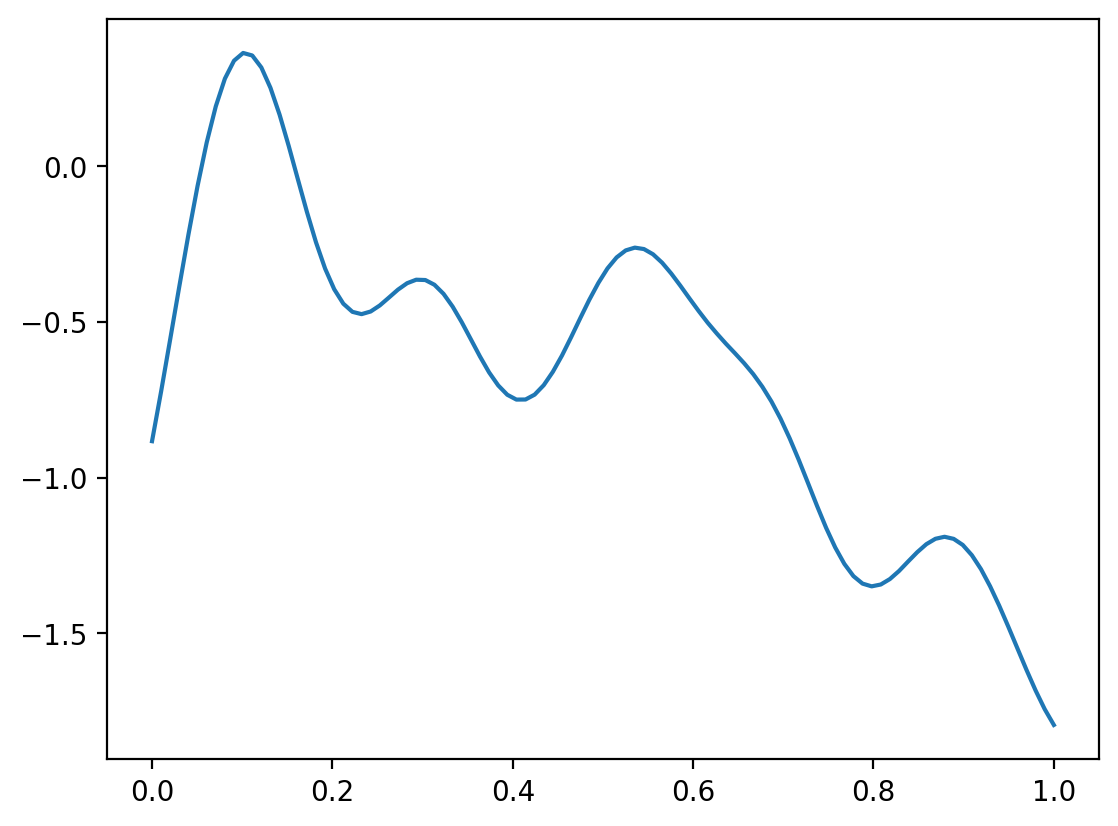

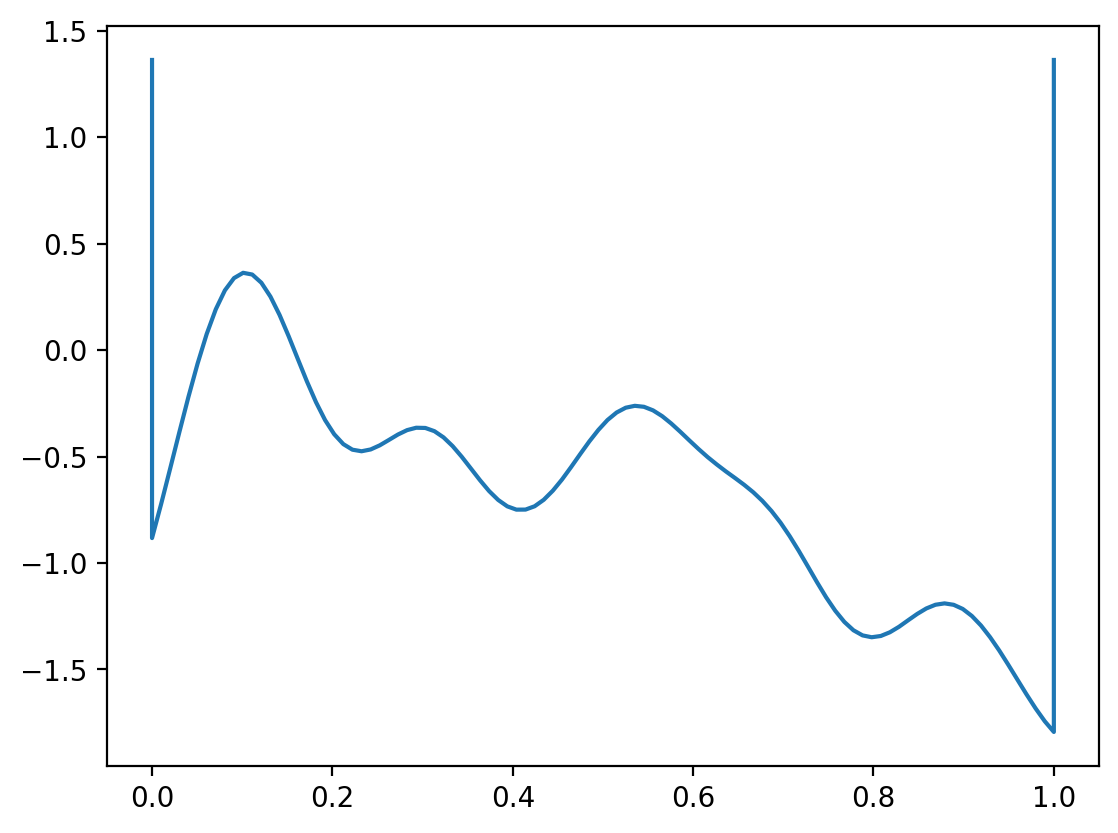

In [478]:
plt.plot(x, fs.T)

plt.figure(); plt.plot(x_pad, fs_pad.T)


In [480]:
np.column_stack((x_pad, fs_pad[0, :]))

array([[ 0.        ,  1.36316611],
       [ 0.        , -0.88312557],
       [ 0.01010101, -0.72292924],
       [ 0.02020202, -0.55495096],
       [ 0.03030303, -0.38529361],
       [ 0.04040404, -0.2191482 ],
       [ 0.05050505, -0.06349589],
       [ 0.06060606,  0.07556783],
       [ 0.07070707,  0.1918512 ],
       [ 0.08080808,  0.28079796],
       [ 0.09090909,  0.33826262],
       [ 0.1010101 ,  0.36316611],
       [ 0.11111111,  0.35503808],
       [ 0.12121212,  0.31653636],
       [ 0.13131313,  0.25116452],
       [ 0.14141414,  0.16523367],
       [ 0.15151515,  0.06507564],
       [ 0.16161616, -0.04136969],
       [ 0.17171717, -0.14687991],
       [ 0.18181818, -0.2447324 ],
       [ 0.19191919, -0.32908876],
       [ 0.2020202 , -0.39536098],
       [ 0.21212121, -0.44173497],
       [ 0.22222222, -0.4679112 ],
       [ 0.23232323, -0.47528453],
       [ 0.24242424, -0.46679278],
       [ 0.25252525, -0.44741873],
       [ 0.26262626, -0.4221945 ],
       [ 0.27272727,

In [481]:
fs_pad[0, :]

array([ 1.36316611, -0.88312557, -0.72292924, -0.55495096, -0.38529361,
       -0.2191482 , -0.06349589,  0.07556783,  0.1918512 ,  0.28079796,
        0.33826262,  0.36316611,  0.35503808,  0.31653636,  0.25116452,
        0.16523367,  0.06507564, -0.04136969, -0.14687991, -0.2447324 ,
       -0.32908876, -0.39536098, -0.44173497, -0.4679112 , -0.47528453,
       -0.46679278, -0.44741873, -0.4221945 , -0.3965618 , -0.37599468,
       -0.36476544, -0.36578034, -0.38093394, -0.41005903, -0.45114043,
       -0.50116535, -0.55605518, -0.61117209, -0.66216509, -0.70402504,
       -0.73408549, -0.74958022, -0.7492956 , -0.7337132 , -0.70331541,
       -0.66047831, -0.60833746, -0.54971201, -0.48881984, -0.42932823,
       -0.37499334, -0.32847312, -0.29319546, -0.27067861, -0.26177737,
       -0.26635054, -0.28315156, -0.31028677, -0.3449933 , -0.38406054,
       -0.42490164, -0.46489902, -0.5028473 , -0.53743281, -0.57013195,
       -0.60100245, -0.6328625 , -0.66782769, -0.70836971, -0.75

# Computations


Compare:
* 1d and 2d convex hull constructions
* biconjugate computation
* qhull + something

# 1D vs 2D

Time the current biconjugate computation

CPU times: user 38.4 ms, sys: 1.22 ms, total: 39.6 ms
Wall time: 47.4 ms
CPU times: user 21.8 ms, sys: 257 µs, total: 22.1 ms
Wall time: 22.1 ms
CPU times: user 1.93 ms, sys: 174 µs, total: 2.11 ms
Wall time: 2.11 ms
CPU times: user 4.85 ms, sys: 166 µs, total: 5.02 ms
Wall time: 5.18 ms
CPU times: user 1.83 ms, sys: 151 µs, total: 1.99 ms
Wall time: 1.99 ms
CPU times: user 2.93 ms, sys: 14 µs, total: 2.94 ms
Wall time: 2.98 ms
CPU times: user 1.85 ms, sys: 148 µs, total: 2 ms
Wall time: 2.01 ms
CPU times: user 2.83 ms, sys: 25 µs, total: 2.85 ms
Wall time: 2.87 ms
CPU times: user 1.97 ms, sys: 181 µs, total: 2.15 ms
Wall time: 2.17 ms
CPU times: user 2.76 ms, sys: 11 µs, total: 2.77 ms
Wall time: 2.78 ms


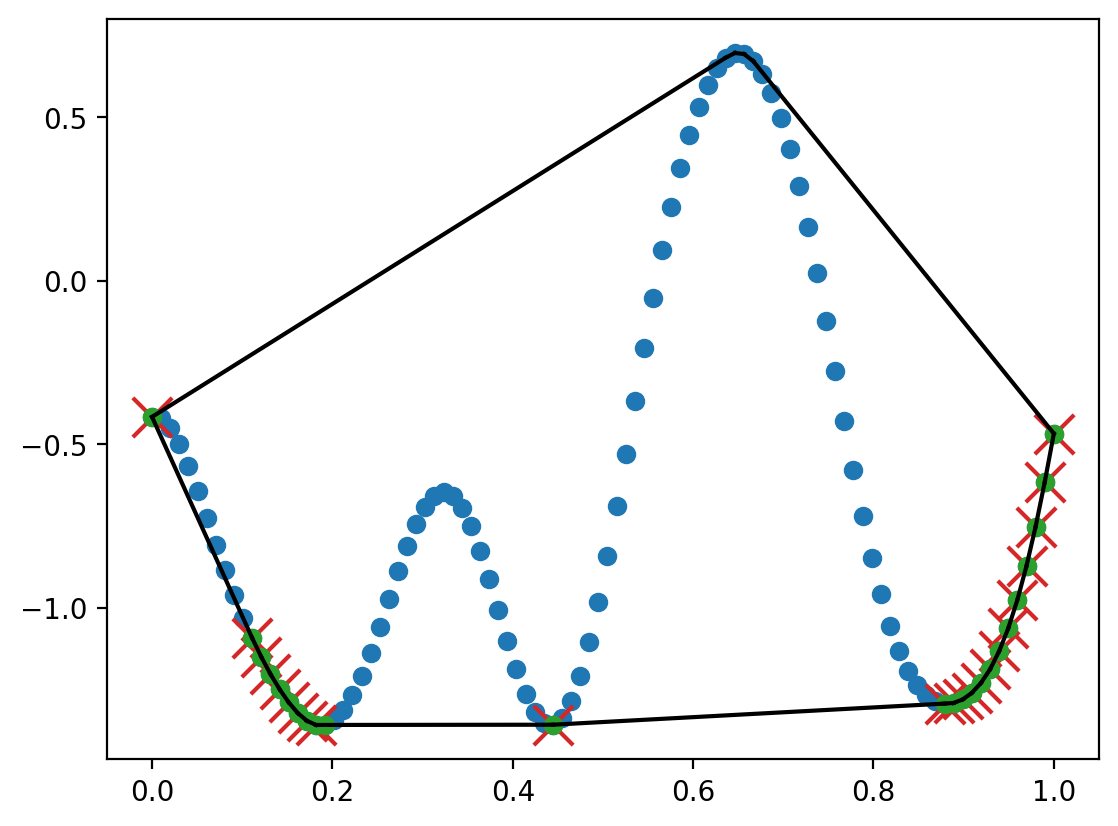

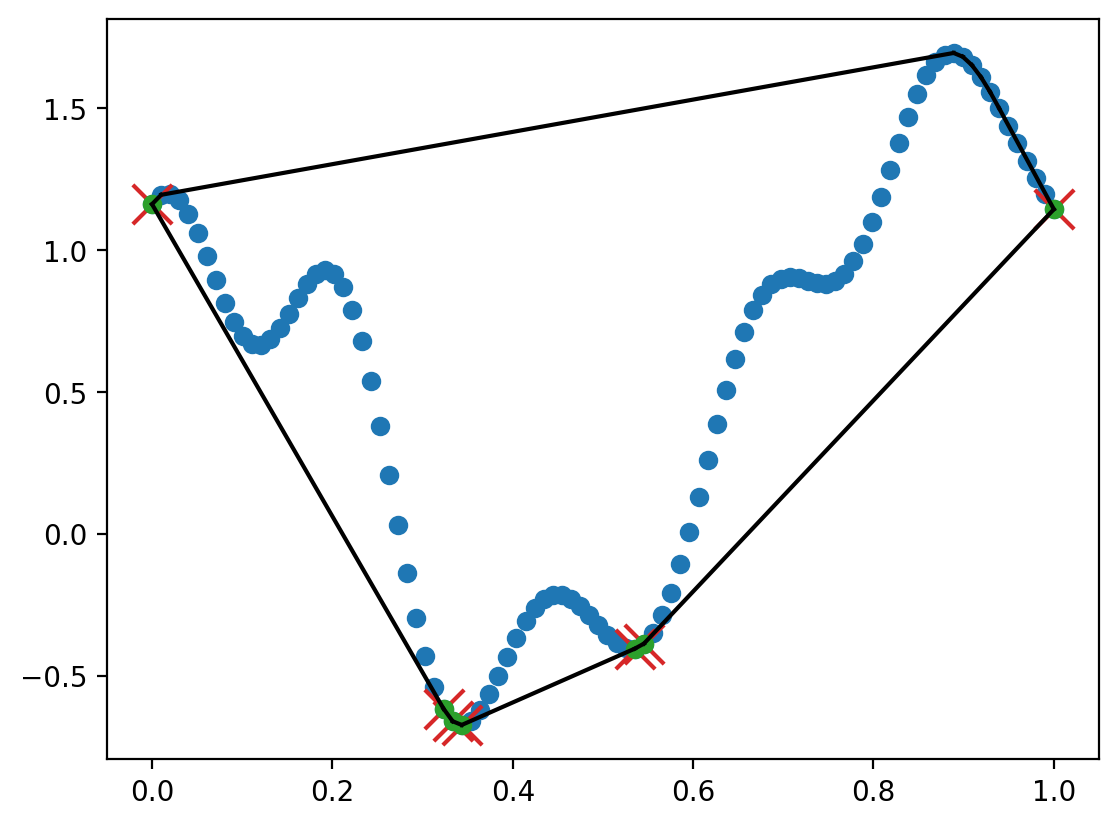

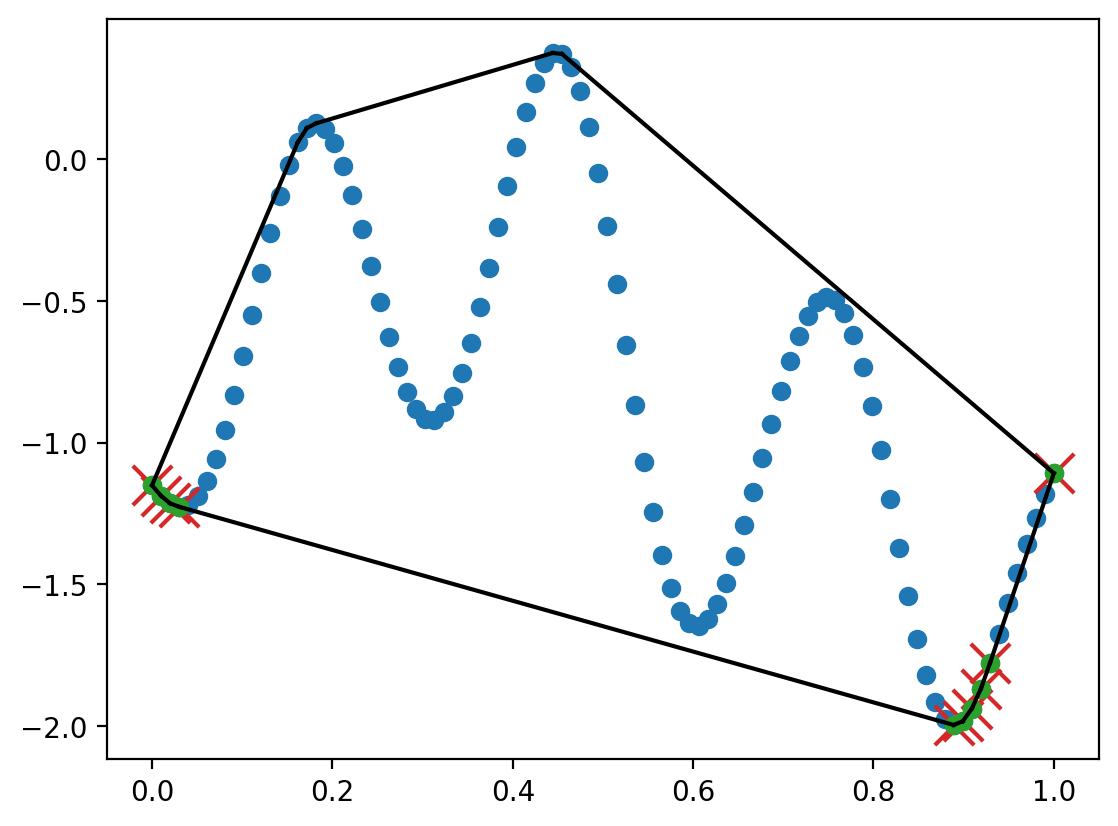

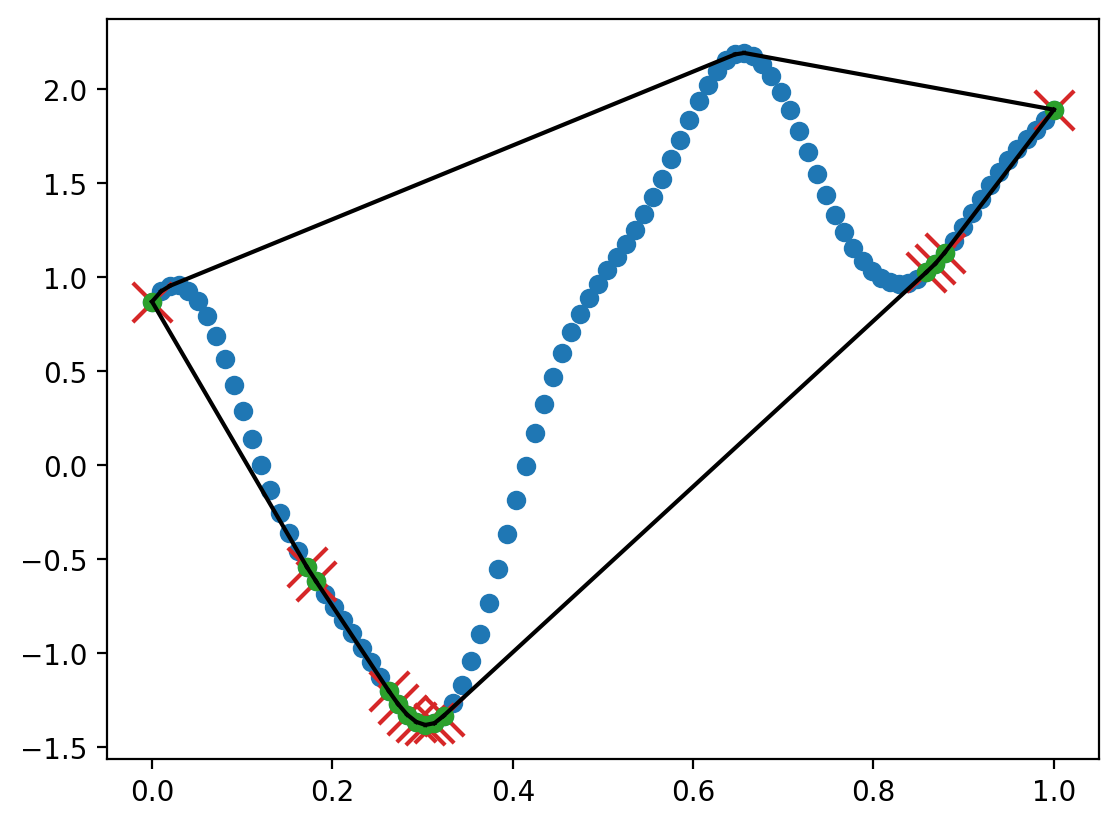

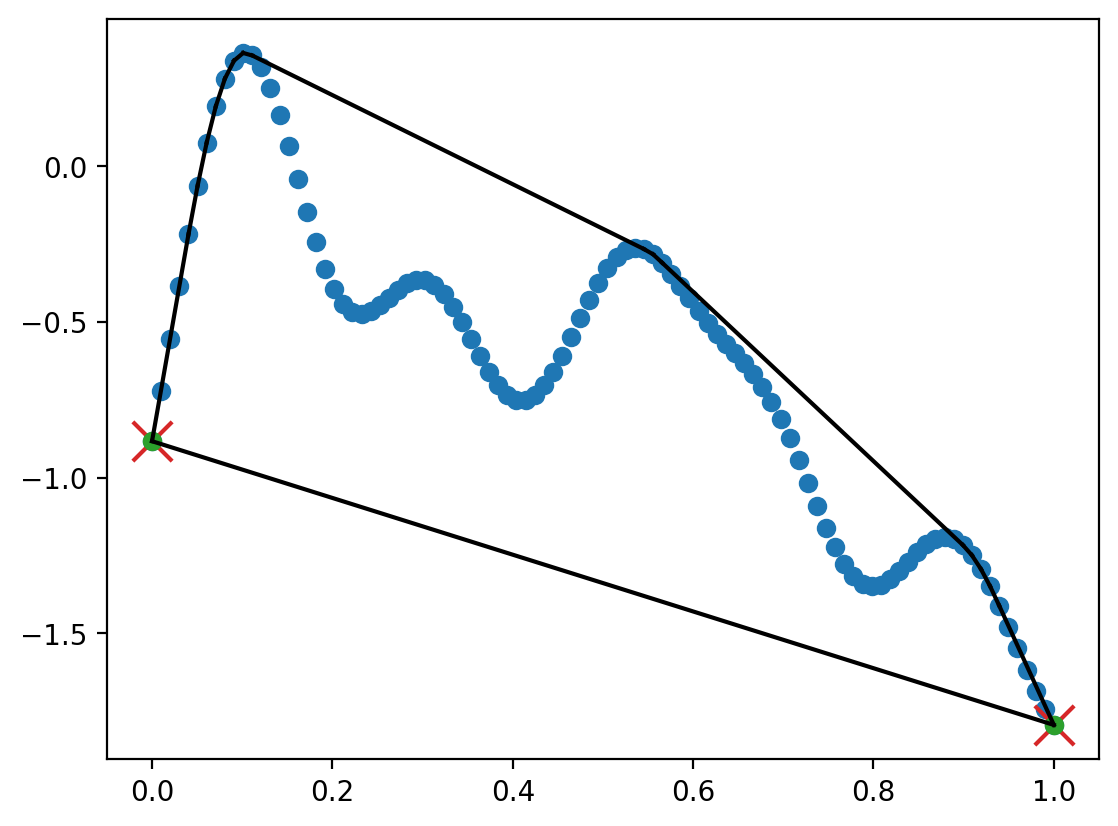

In [422]:
seed = 2
num_iters = 6
knot_N = 100
npr.seed(seed); rng_key = jrnd.PRNGKey(seed)

# grid to discretize design space into
knot_x = jnp.linspace(0, 1, knot_N)
design_space = knot_x[:, jnp.newaxis]

for ind in range(5):
    true_y, true_envelope = generate_true_function(design_space, knot_N)
    
    plt.figure(); plt.scatter(design_space, true_y)
    points = np.hstack([design_space, true_y[:, np.newaxis]])
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
        
    %time hullvals = convex_envelope(design_space, true_y)[0]

    for i in hullvals:
        plt.scatter(design_space[i], true_y[i], c="tab:red", marker="x", s=200)
        
    
    %time hull2 = convelope(design_space, true_y)[0]
    tights2 = np.abs(hull2 - true_y) <= 1e-3
    
    for i, val in enumerate(tights2):
        if val == True:
            plt.scatter(design_space[i], true_y[i], marker="o", c="tab:green")

In [415]:
tights2

array([ True, False, False, False, False,  True,  True, False, False,
       False, False, False,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False,  True])

In [397]:
"""
plt.plot(design_space, true_y)
plt.plot(design_space, true_envelope.T)

s = is_tight(design_space, true_y).astype("int32")
s_ind = np.where(s == 1)[0]
plt.scatter(design_space[s_ind], true_y[s_ind])
"""

'\nplt.plot(design_space, true_y)\nplt.plot(design_space, true_envelope.T)\n\ns = is_tight(design_space, true_y).astype("int32")\ns_ind = np.where(s == 1)[0]\nplt.scatter(design_space[s_ind], true_y[s_ind])\n'

Array([[ 1.1615215 ,  1.02533075,  0.88914   ,  0.75294925,  0.617969  ,
         0.48423214,  0.35049528,  0.2441546 ,  0.13986439,  0.03557417,
        -0.06871604, -0.17300625, -0.27729647, -0.38158668, -0.48587689,
        -0.59016711, -0.69445732, -0.79874753, -0.90303774, -1.00732796,
        -1.11161817, -1.21590838, -1.3201986 , -1.33029474, -1.30452892,
        -1.27876311, -1.25299729, -1.22723147, -1.20146565, -1.17569984,
        -1.14993402, -1.1241682 , -1.09840239, -1.07263657, -1.04687075,
        -1.02110493, -0.99533912, -0.9695733 , -0.94380748, -0.91804166,
        -0.89227585, -0.86651003, -0.84074421, -0.81497839, -0.78921258,
        -0.7623855 , -0.73416579, -0.70594609, -0.67772638, -0.64005233]],      dtype=float64)

In [404]:
%timeit convelope(design_space, true_y)

2.07 ms ± 66.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [405]:
%timeit convex_envelope(design_space, true_y)

2.19 ms ± 162 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [392]:
"""
def get_tight(design_space, true_y):
    points = np.hstack([design_space, true_y[:, np.newaxis]])
    hull = ConvexHull(points)
    s = np.zeros(len(design_space))
    s[hull.vertices] = 1
    return s
"""

## 2D

In [35]:
n_grid = 11

nx, ny = (n_grid, n_grid)
x = jnp.linspace(0, 1, nx)
y = jnp.linspace(0, 1, ny)
xv, yv = jnp.meshgrid(x, y)
train_x = jnp.array([xv.flatten(),yv.flatten()]).T
# filter out points that are greater than 1
design_space = train_x[train_x.sum(1) <= 1]
pts = []
for x in design_space:
    pts.append(jnp.array([x[0], x[1], 1-x.sum()]))
    
knot_N = len(design_space)

#set seed
seed = 5
npr.seed(seed); rng_key = jrnd.PRNGKey(seed)

# generate energies
true_y, true_envelope = generate_true_function(design_space, knot_N)

# compute tight points w.r.t. generated data
tights = (true_y - true_envelope) <= 1e-3
tight_designs = design_space[tights.ravel(),:]
tight_pts = []
for x in tight_designs:
    tight_pts.append(jnp.array([x[0], x[1], 1-x.sum()]))

# observations at each vertex and roughly in the middle
train_x = jnp.array([design_space[0], design_space[10], design_space[24], design_space[-1]])
train_y = jnp.array([true_y[0], true_y[10], true_y[24], true_y[-1]])
data = (train_x, train_y); #dataset = Dataset(X=train_x, y=train_y[:,jnp.newaxis])

In [36]:
%timeit convelope(design_space, true_y)

96.1 ms ± 1.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [37]:
%timeit is_tight(design_space, true_y)

NameError: name 'is_tight' is not defined

In [ ]:
%timeit convex_envelope(design_space, true_y)

In [ ]:
chull = convelope(design_space, true_y)

In [ ]:
chull2 = np.array(convex_envelope(design_space, true_y)[0])

In [ ]:
ax = plt.figure().add_subplot(projection='3d')

ax.plot_trisurf(design_space[:,0], design_space[:,1], true_y, linewidth=0, antialiased=False, alpha=0.7)
ax.plot_trisurf(design_space[:,0], design_space[:,1], chull.ravel(), linewidth=0, antialiased=False, alpha=0.7)

ax.set_xlabel("$x$"); ax.set_ylabel("$1-x$"); ax.set_zlabel("energy")

In [ ]:
design_space.shape[1]

In [ ]:
ax = plt.figure().add_subplot(projection='3d')

ax.plot_trisurf(design_space[:,0], design_space[:,1], true_y, linewidth=0, antialiased=False, alpha=0.7)
ax.plot_trisurf(design_space[chull2,0], design_space[chull2,1], true_y[chull2], linewidth=0, antialiased=False, alpha=0.7)

ax.set_xlabel("$x$"); ax.set_ylabel("$1-x$"); ax.set_zlabel("energy")

In [ ]:
def convex_envelope(x, fs):
    """Computes convex envelopes of M functions which share a common grid.
    x is an (N, D)-matrix corresponding to the grid in D-dimensional space and fs is an (M, N)-matrix.
    The i-th function is given by the pairs (x[0], fs[i, 0]), ..., (x[N-1], fs[i, N-1]).
    The envelopes are returned as a list of lists.
    The i-th list is of the form [j_1, j_2, ..., j_n] where (X[j_k], fs[i, j_k]) is a point in the envelope.
    
    Keyword arguments:
    x  -- A shape=(N,D) numpy array.
    fs -- A shape=(M,N) or shape=(N,) numpy array."""
    
    #assert(len(fs.shape) <= 2)
    if len(fs.shape) == 1: fs = np.reshape(fs, (-1, fs.shape[0]))
    M, N = fs.shape
    
    assert(len(x.shape) <= 2)
    if len(x.shape) == 1: x = np.reshape(x, (-1, 1))
    assert(x.shape[0] == N)
    D = x.shape[1]
    
    fs_pad = np.empty((M, N+2))
    fs_pad[:, 1:-1], fs_pad[:, (0,-1)] = fs, np.max(fs) + 1. ## TODO: can't do this
    
    x_pad = np.empty((N+2, D))
    x_pad[1:-1, :], x_pad[0, :], x_pad[-1, :] = x, x[0, :], x[-1, :]
    
    results = []
    for i in range(M):
        epi = np.column_stack((x_pad, fs_pad[i, :]))
        hull = ConvexHull(epi)
        result = [v-1 for v in hull.vertices if 0 < v <= N]
        result.sort()
        results.append(np.array(result))
    
    return np.array(results)

In [ ]:
convex_envelope(points[:, :-1], points[:, -1])

In [ ]:
points[:, :-1].shape

In [ ]:
true_y.shape

In [ ]:
def is_vertex(points):
    N, D = points.shape
    #vertices = ConvexHull(points).vertices
    vertices = convex_envelope(points[:, :-1], points[:, -1])[0]
    s = np.zeros(N)
    s[vertices] = 1
    return s
    
    
def is_tight(design_space, true_y):

    points = jnp.hstack([design_space, true_y[:, jnp.newaxis]])
    #hull = ConvexHull(points)
    _scipy_hull = lambda points: is_vertex(points) #.astype(points.dtype)
    #s = np.zeros(len(design_space))
    #s[hull.vertices] = 1

    result_shape_dtype = jax.ShapeDtypeStruct(
          shape=jnp.broadcast_shapes(true_y.shape),
          dtype='float64')

    return jax.pure_callback(_scipy_hull, result_shape_dtype, points, vectorized=True)

In [ ]:
is_tight(design_space, true_y)

In [ ]:
chull2[0]

In [ ]:
true_y[chull2]

In [ ]:
def jv(v, z):
    import scipy
    v, z = jnp.asarray(v), jnp.asarray(z)

    # Require the order v to be integer type: this simplifies
    # the JVP rule below.
    assert jnp.issubdtype(v.dtype, jnp.integer)

    # Promote the input to inexact (float/complex).
    # Note that jnp.result_type() accounts for the enable_x64 flag.
    z = z.astype(jnp.result_type(float, z.dtype))

    # Wrap scipy function to return the expected dtype.
    _scipy_jv = lambda v, z: scipy.special.jv(v, z).astype(z.dtype)

    # Define the expected shape & dtype of output.
    result_shape_dtype = jax.ShapeDtypeStruct(
      shape=jnp.broadcast_shapes(v.shape, z.shape),
      dtype=z.dtype)

    # We use vectorize=True because scipy.special.jv handles broadcasted inputs.
    return jax.pure_callback(_scipy_jv, result_shape_dtype, v, z, vectorized=True)

In [ ]:
import scipy

In [ ]:
v = jnp.asarray(1)
z = jnp.arange(5.0)

_scipy_jv = lambda v, z: scipy.special.jv(v, z).astype(z.dtype)

result_shape_dtype = jax.ShapeDtypeStruct(
      shape=jnp.broadcast_shapes(v.shape, z.shape),
      dtype=z.dtype)

output = jax.pure_callback(_scipy_jv, result_shape_dtype, v, z, vectorized=True)

In [ ]:
z.shape

In [ ]:
_scipy_jv(1, z).shape

In [ ]:
from functools import partial
j1 = partial(jv, 1)
z = jnp.arange(5.0)
print(jax.vmap(j1)(z))


In [ ]:
def get_tight(design_space, true_y):
    design_np = np.array(design_space)
    true_y_np = np.array(true_y)
    points = np.hstack([design_np, true_y_np[:, np.newaxis]])
    
    _scipy_hull = lambda points: ConvexHull(points).astype(points.dtype)
    #_scipy_jv = lambda v, z: scipy.special.jv(v, z).astype(z.dtype)
    s = np.zeros(len(design_space))
    s[np.array(hull.vertices)] = 1
    return jnp.array(s)

In [ ]:
_scipy_hull = lambda points: ConvexHull(points).astype(points.dtype)

In [ ]:
wrap_get_tight = lambda a, b: jnp.array(get_tight(a, b))

In [38]:
output = wrap_get_tight(design_space, true_y)

get_tight_jax = jax.vmap(wrap_get_tight, in_axes=(0,None))

NameError: name 'wrap_get_tight' is not defined

In [39]:
all_designs = jnp.array([design_space, design_space])
all_ys = jnp.array([true_y, true_y])

In [40]:
np.array(design_space)

array([[0. , 0. ],
       [0.1, 0. ],
       [0.2, 0. ],
       [0.3, 0. ],
       [0.4, 0. ],
       [0.5, 0. ],
       [0.6, 0. ],
       [0.7, 0. ],
       [0.8, 0. ],
       [0.9, 0. ],
       [1. , 0. ],
       [0. , 0.1],
       [0.1, 0.1],
       [0.2, 0.1],
       [0.3, 0.1],
       [0.4, 0.1],
       [0.5, 0.1],
       [0.6, 0.1],
       [0.7, 0.1],
       [0.8, 0.1],
       [0.9, 0.1],
       [0. , 0.2],
       [0.1, 0.2],
       [0.2, 0.2],
       [0.3, 0.2],
       [0.4, 0.2],
       [0.5, 0.2],
       [0.6, 0.2],
       [0.7, 0.2],
       [0.8, 0.2],
       [0. , 0.3],
       [0.1, 0.3],
       [0.2, 0.3],
       [0.3, 0.3],
       [0.4, 0.3],
       [0.5, 0.3],
       [0.6, 0.3],
       [0.7, 0.3],
       [0. , 0.4],
       [0.1, 0.4],
       [0.2, 0.4],
       [0.3, 0.4],
       [0.4, 0.4],
       [0.5, 0.4],
       [0.6, 0.4],
       [0. , 0.5],
       [0.1, 0.5],
       [0.2, 0.5],
       [0.3, 0.5],
       [0.4, 0.5],
       [0.5, 0.5],
       [0. , 0.6],
       [0.1,